# Machine Learning Regression Example

### Problem Statement

The goal of this project is to build a machine learning model capable of predicting the Manufacturer's Suggested Retail Price (MSRP) of a vehicle, utilizing a dataset containing various vehicle attributes, such as make, model, year, engine specifications, and other relevant features.

In [2]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, mutual_info_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer


## Prepare the data and Exploratory Data Analysis (EDA):

In [3]:
df = pd.read_csv('./data.csv', iterator=False)
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Data Preparation

In [4]:
# follow standards, transform the column names to lower case and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

# fill the missing values with 0
df.fillna(0, inplace=True)

# rename msrp to price
df.rename(columns={'msrp': 'price'}, inplace=True)

df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,price
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Exploratory Data Analysis

Find the strongest linear connections within the numerical part of the dataset, to set the stage for further analysis, feature engineering, or model building.

In [5]:
def find_max_correlation(correlation_matrix, target= ''):
    """
    Find the maximum correlation between features in a correlation matrix.
    Return the names of the two features and the correlation value.
    """
    # Exclude diagonal elements (self-correlation)
    np.fill_diagonal(correlation_matrix.values, np.nan)
        
    if (target == ''):      
        correlation = correlation_matrix  
        # Find the indices of the maximum correlation
        max_corr_index = np.nanargmax(correlation.values)
        max_corr_row, max_corr_col = np.unravel_index(max_corr_index, correlation.shape)
        
        # Identify the features with the highest correlation
        feature1 = correlation_matrix.columns[max_corr_row]
        feature2 = correlation_matrix.columns[max_corr_col]
        max_corr_value = correlation_matrix.iloc[max_corr_row, max_corr_col]
        
        return feature1, feature2, max_corr_value
    else:
       # Get correlations with the target, excluding the target itself
        target_correlations = correlation_matrix[target].drop(target)
        
        # Find the index of the maximum correlation
        max_corr_index = np.nanargmax(np.abs(target_correlations.values))
        
        # Identify the features with the highest correlation
        feature1 = target_correlations.index[max_corr_index]
        max_corr_value = target_correlations.iloc[max_corr_index]

        return feature1, max_corr_value


In [6]:
# lets set the features and the target label
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
target_label = 'price'

print('Numerical Features:', numerical_features)
print('Categorical Features:', categorical_features)
print('Target Label:', target_label)


Numerical Features: ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity', 'price']
Categorical Features: ['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']
Target Label: price


### What are the two features that have the biggest correlation in this dataset?

- if you build a linear model, you'll likely see unstable or misleading coefficients if you include both.
- Consider dropping one of them or creating a new feature that combines them in a meaningful way. For example, horsepower/engine_size ratio.

In [7]:
print(f'Numeric features: {numerical_features}')

# Create the correlation matrix for the numerical features of your dataset. 
# In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset
corr_matrix = df[numerical_features].corr()
print(f'Correlation Matrix: \n{corr_matrix}\n')

feature1, feature2, max_corr_value = find_max_correlation(corr_matrix)
print(f'Highest Correlation - Feature 1: {feature1} Feature 2: {feature2} ')
print(f'Highest Correlation Value (Stronger as is closer to 1): {max_corr_value:.2f}')


Numeric features: ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity', 'price']
Correlation Matrix: 
                      year  engine_hp  engine_cylinders  number_of_doors  \
year              1.000000   0.338714         -0.040708         0.261431   
engine_hp         0.338714   1.000000          0.774851        -0.104588   
engine_cylinders -0.040708   0.774851          1.000000        -0.136669   
number_of_doors   0.261431  -0.104588         -0.136669         1.000000   
highway_mpg       0.258240  -0.415707         -0.614541         0.102457   
city_mpg          0.198171  -0.424918         -0.587306         0.104597   
popularity        0.073049   0.031409          0.045226        -0.048177   
price             0.227590   0.650095          0.526274        -0.128627   

                  highway_mpg  city_mpg  popularity     price  
year                 0.258240  0.198171    0.073049  0.227590  
engine_hp           -0.415707 -0.4249

### Find the features are have the most correlation with the target feature

In [8]:
feature, max_corr = find_max_correlation(corr_matrix, target='price')
print(f"With Target - Max correlation with 'price' is '{feature}': {max_corr:.2f}")

With Target - Max correlation with 'price' is 'engine_hp': 0.65


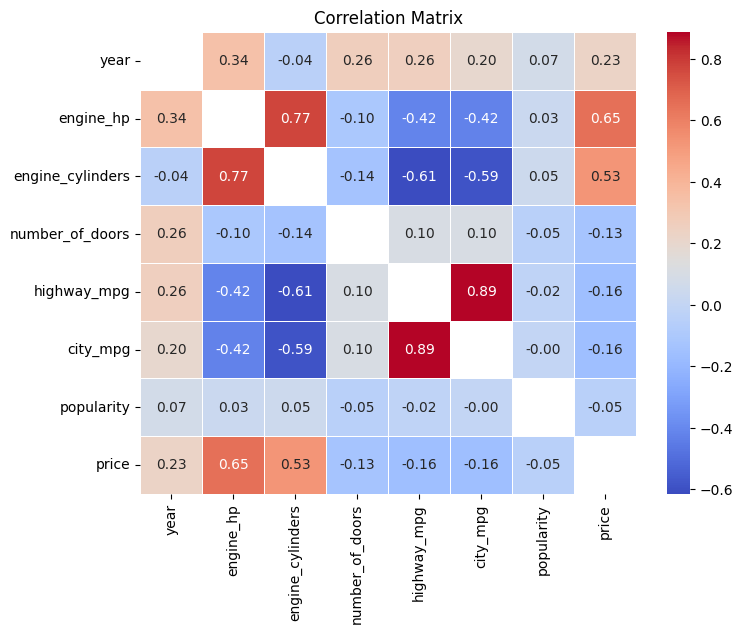

In [10]:
# visualize the correlation matrix
# Create the Heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Feature Engineering Conclusion
- High correlation between independent variables (highway_mpg, city_mpg) means multicollinearity, and you should generally remove one.
- High correlation between an independent variable and the target variable (engine_hp, price) is good and means that feature is important, you should keep that.

In [79]:
# get the features
if 'city_mpg' in numerical_features:
    numerical_features.remove('city_mpg')

some_cat_features = ['make', 'model', 'transmission_type', 'vehicle_style']  

#  define the categories your need. we use a sample for speed here  
all_features = numerical_features + some_cat_features

X = df[all_features]  # Features
y = df['price']       # Target
print (all_features)

['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'popularity', 'price', 'make', 'model', 'transmission_type', 'vehicle_style']


# Split the data
- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value (price) is not in your dataframe.

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reset the indexes of the dataframes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# remove the target column from the features X, y is the target
X_train = X_train.drop(columns=['price'])
X_test = X_test.drop(columns=['price'])

print('train data length: ',len(X_train),'price values length: ', len(y_train))

train data length:  9531 price values length:  9531


### Which of these variables has the lowest mutual information score?

- Calculate the mutual information score between target and other categorical variables in our dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).


In [110]:
from sklearn.feature_selection import mutual_info_regression

def plot_mi_scores(scores):
    """
    Plots the mutual information scores in a bar chart.

    Args:
        scores: A pandas Series containing the MI scores.
    """
    scores = scores.sort_values(ascending=True)
    width = 0.85
    plt.figure(dpi=100, figsize=(6, 3))
    plt.barh(scores.index, scores.values, width)
    plt.title("Mutual Information Scores")
    plt.xlabel("MI Score")
    plt.ylabel("Feature")
    plt.show()


# One-Hot Encoding of string columns
# must use the same for validation and test data
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

def encode_data(X, encoder, training=True):
    """
    Encode the data using One-Hot Encoding.
    """        
    # Transform the training data
    if training:
        X_encoded = encoder.fit_transform(X.values)
    else:   
        X_encoded = encoder.transform(X.values)

    # Convert X_encoded to DataFrame
    df_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(X.columns))
    
    return df_encoded

def mutual_score(X, y):
        
    print(X.shape, y.shape)       
        
    # Calculate the mutual information score between 'above_average' and other categorical variables
    def mutual_info_price_score(X):
        return mutual_info_score(X, y)
    
    mi_scores = X.apply(mutual_info_price_score)                  
        
    # Sort MI scores in descending order
    mi_scores = mi_scores.sort_values(ascending=False).round(2)
   
    top_scores = mi_scores[mi_scores > 0.1]
     # Print the MI scores
    print(mi_scores)
    plot_mi_scores(top_scores)

    # Feature selection - Select only features with MI > 0.1 (adjust the threshold as needed)
    selected_features = top_scores.index.tolist()   

    return selected_features


(9531, 4) (9531,)
model                0.54
make                 0.19
vehicle_style        0.09
transmission_type    0.05
dtype: float64


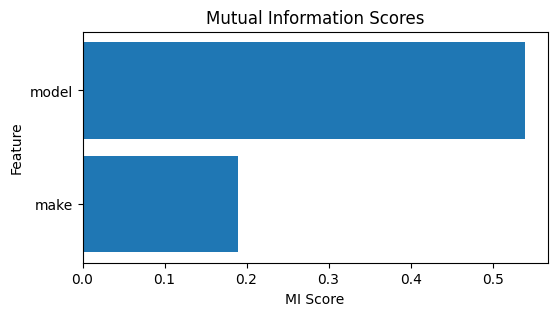

Selected Features > .1: ['model', 'make']


In [89]:
# let's create a binary column that indicates if the price is above the median price
price_median = y_train.median()
y_above_average = (y_train > price_median).astype(int)
# y_above_average.head()

X_score = X_train[some_cat_features]
selected_features = mutual_score(X_score, y_above_average)
print(f'Selected Features > .1: {selected_features}')

### Model Selection and training

 - Linear Regression
 - Random Forest Regression


In [111]:
def model_training(model, X_train, y_train, X_test, y_test):
    """
    Train a model and return the predictions on the test set.
    """
    if (not model):
        return None

    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict the target
    y_pred = model.predict(X_test)
    
    return y_pred

def feature_encoding(X, categories, encoder, training=True):
    """
    Encode the training and test data using One-Hot Encoding.
    """
    X_cats = X[categories]
    X_nums = X.drop(columns=categories)
    X_encoded = encode_data(X_cats, encoder, training)

    X_nums.reset_index(drop=True, inplace=True)
    X_encoded.reset_index(drop=True, inplace=True)

    X_processed = pd.concat([X_nums,X_encoded], axis=1)    

    print(X_processed.shape)

    return X_processed



In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X_train_encoded = feature_encoding(X_train, some_cat_features, encoder)
print(X_train_encoded.shape, y_train.shape)

# Ensure the number of rows in X_train_encoded matches y_train
assert X_train_encoded.shape[0] == y_train.shape[0], "Mismatch in number of samples between X_train_encoded and y_train"

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

(9531, 977)
(9531, 977) (9531,)


LinearRegression()

In [113]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

RandomForestRegressor(random_state=42)

### Make Predictions and evaluate the models

In [116]:
#  Make Predictions 
X_test_encoded = feature_encoding(X_test, some_cat_features, encoder, False)
print(X_test_encoded.shape)

lr_predictions = lr_model.predict(X_test_encoded)
rf_predictions = rf_model.predict(X_test_encoded)

# Create a DataFrame to display make, model_year, and predictions
results_df = X_test[['make','model', 'year']].copy()
results_df['price_liner_reg'] = lr_predictions
results_df['price_ran_forest'] = rf_predictions

print(results_df.head())

(2383, 977)
(2383, 977)
         make     model  year  price_liner_reg  price_ran_forest
0         GMC  Envoy XL  2005     32962.232300      33434.983333
1  Volkswagen    Passat  2016     25992.253784      26842.900698
2       Honda   Odyssey  2016     36135.430786      36959.897619
3   Chevrolet     Cruze  2015     17891.056274      17468.639167
4       Volvo       740  1991      4889.470825       2000.000000


### Evaluate the Models

- **MAE (Mean Absolute Error):**
    - What it is: The average absolute difference between the predicted values and the actual values.  

    - Interpretation: Lower is better. A lower MAE means the model's predictions are, on average, closer to the actual values.

- **MSE (Mean Squared Error):**
    - What it is: The average of the squared differences between the predicted values and the actual values. It penalizes larger errors more heavily than MAE.
    - Interpretation: Lower is better. A lower MSE means the model's predictions have smaller squared deviations from the actual values.
  
- **R² (R-squared):**
    - What it is: A measure of how well the model explains the variance in the target variable. 
    - Interpretation: Closer to 1 is better.
    - R² = 1 means the model perfectly predicts the data.
    - R² = 0 means the model does not explain any of the variance.
    - R² < 0 means the model does not predict the data better than a horizontal line. This means the model is very bad.

In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def model_evaluation(y_test, y_pred, model_name):
    """
    Evaluate the model using accuracy and classification report.
    """
    # Linear Regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  

    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'R²': r2
    }  

In [142]:
# Evaluate and store results
metrics = []
lr_metrics = model_evaluation(y_test, lr_predictions, "Linear Regression")
rf_metrics = model_evaluation(y_test, rf_predictions, "Random Forest Regressor")
metrics.append(lr_metrics)
metrics.append(rf_metrics)

# Create a DataFrame from the results
metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison DataFrame:")
print(metrics_df)


Model Comparison DataFrame:
                     Model           MAE           MSE            R²
0        Linear Regression  5.853769e+09  6.620329e+21 -2.777485e+12
1  Random Forest Regressor  3.108429e+03  7.124401e+07  9.701104e-01


In [143]:
def plot_predicted_vs_actual(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Plot for {model_name}')
    plt.tight_layout()
    plt.show()

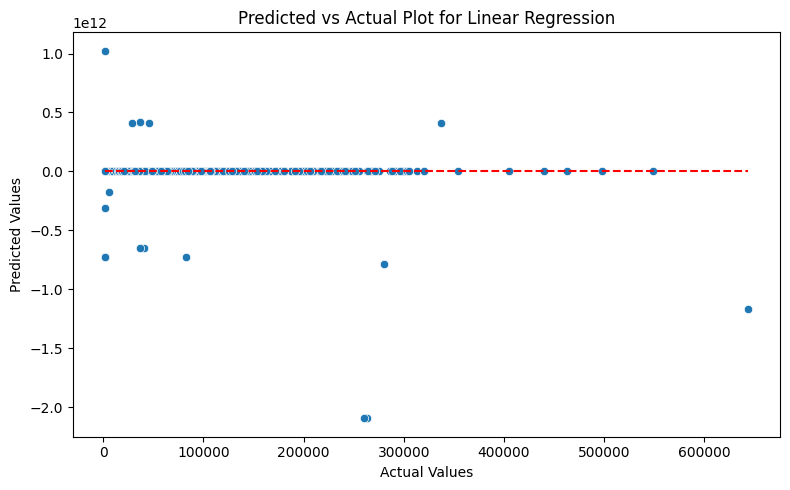

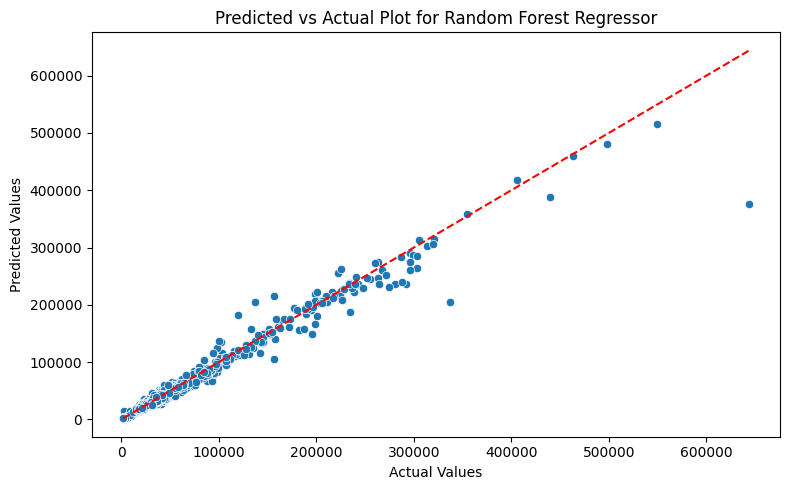

In [144]:
plot_predicted_vs_actual(y_test, lr_predictions, "Linear Regression")
plot_predicted_vs_actual(y_test, rf_predictions, "Random Forest Regressor")

### Save the model and decoder

- Save the model
- Save the encoder as this is required for validation
- The bin files are then used for predictions on a API

In [166]:
# get the model and the encoder and save them to a file
import pickle
import os

def model_export(model, encoder, model_name):
    """
    Export the model and the encoder to a file.
    """

    path = './bin'
    if not os.path.exists(path):
        os.makedirs(path)

    file_path = f'{path}/{model_name}'
    # Save the model to a file
    model_filename = f'{file_path}_model.pkl.bin'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)

    # Save the encoder to a file
    encoder_filename = f'{file_path}_encoder.pkl.bin'
    with open(encoder_filename, 'wb') as dv_file:
        pickle.dump(encoder, dv_file)    


In [167]:
model_export(rf_model, encoder, 'random_forest_regressor')
!ls -l ./bin

total 44860
-rw-r--r-- 1 ozkary ozkary    10759 Feb 25 18:05 random_forest_regressor_encoder.pkl.bin
-rw-r--r-- 1 ozkary ozkary 45921637 Feb 25 18:05 random_forest_regressor_model.pkl.bin


### How to use the final model

In [162]:

def model_import(model_name):
    """
    Import the model and the encoder from a file.
    """
    file_path = f'./bin/{model_name}'
    
    # Load the model from a file
    model_filename = f'{file_path}_model.pkl.bin'
    with open(model_filename, 'rb') as model_file:
        model = pickle.load(model_file)

    # Load the encoder from a file
    encoder_filename = f'{file_path}_encoder.pkl.bin'
    with open(encoder_filename, 'rb') as encoder_file:
        encoder = pickle.load(encoder_file)
    
    return model, encoder


In [169]:
# Example usage
model_loaded, encoder_loaded = model_import('random_forest_regressor')

# Make Predictions using the loaded model and encoder
X_random = X_test.sample(n=1, random_state=42)
X_random_encoded = feature_encoding(X_random, some_cat_features, encoder_loaded, False)
rf_predictions_loaded = model_loaded.predict(X_random_encoded)

# Create a DataFrame to display make, model, year, and predictions
results_df = X_random[['make', 'model', 'year']].copy()
results_df['predicted_price'] = rf_predictions_loaded

print(results_df.head())

(1, 977)
     make     model  year  predicted_price
486  Ford  Freestar  2007     26914.922143
